In [1]:
from matplotlib import pyplot as plt
from path import Path
import cv2

path1 = Path("/data/KITTI/raw_meta/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000000.png")
path2 = Path("/data/KITTI/raw_meta/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000001.png")

img1 = cv2.cvtColor(cv2.imread(path1),cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(cv2.imread(path2),cv2.COLOR_BGR2GRAY)

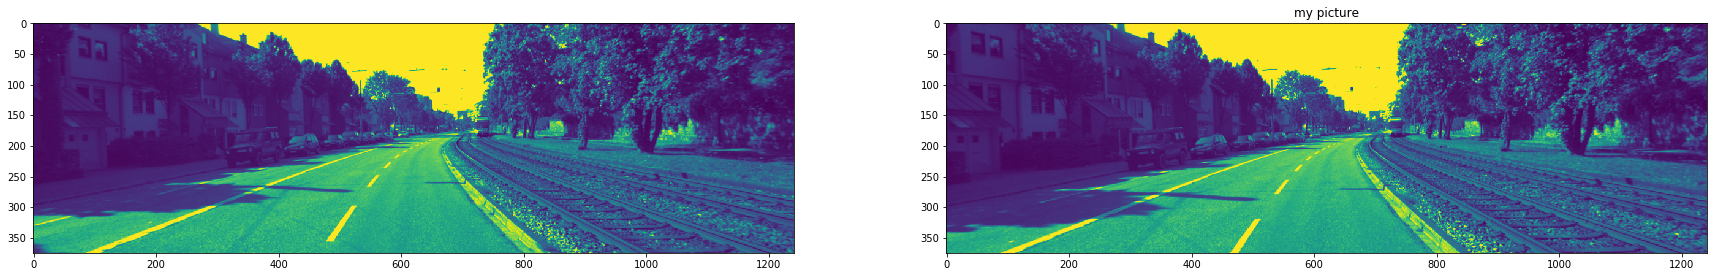

In [2]:
fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(img1)
fig.add_subplot(1, 2, 2)
plt.imshow(img2)

plt.title('my picture')
plt.show()

In [6]:
import numpy as np

sift = cv2.xfeatures2d.SIFT_create(nfeatures=2000, contrastThreshold=1e-5)

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
xy1 = np.array([_kp.pt for _kp in kp1])
xy2 = np.array([_kp.pt for _kp in kp2])

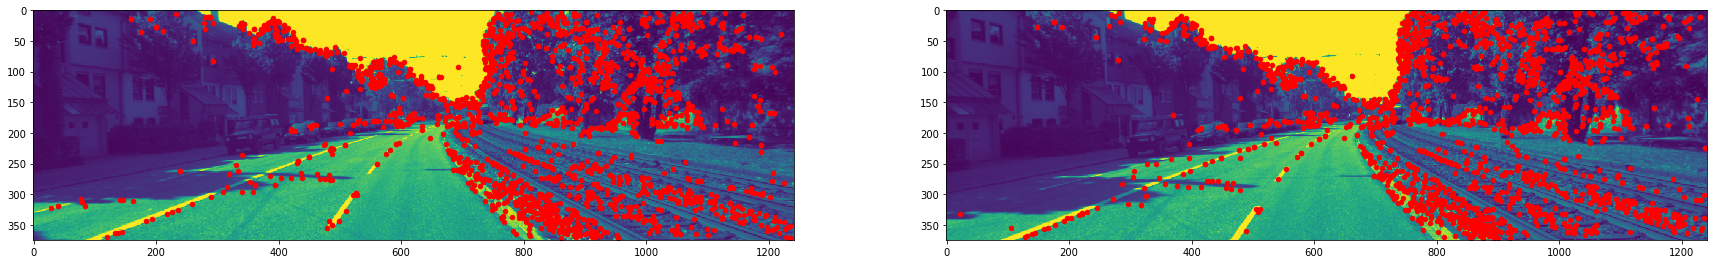

In [16]:
fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(xy1[:,0], xy1[:,1], c="r", s=20)
fig.add_subplot(1, 2, 2)
plt.imshow(img2)
plt.scatter(xy2[:,0], xy2[:,1], c="r", s=20)

plt.show()

In [11]:
def knn_match(x1_all, x2_all, des1, des2, if_BF=False):
        """
        compute correspondence according to knn algorithm
        """

        if if_BF:
            bf = cv2.BFMatcher(normType=cv2.NORM_L2)
            matches = bf.knnMatch(des1, des2, k=2)
        else:
            FLANN_INDEX_KDTREE = 0
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)

            flann = cv2.FlannBasedMatcher(index_params, search_params)
            matches = flann.knnMatch(des1, des2, k=1)

        # good = []
        # all_m = []

        # for m,n in matches:
        #     all_m.append(m)
        #     if m.distance < 0.7*n.distance:
        #         good.append(m)
        
        x1 = x1_all[[mat[0].queryIdx for mat in matches], :]
        x2 = x2_all[[mat[0].trainIdx for mat in matches], :]
        # print("\n")
        # print("shape of x1: {}".format(x1.shape))
        # print("shape of x2: {}".format(x2.shape))
        assert x1.shape == x2.shape

        # print("# good points: {}".format(len(good)))

        return x1, x2
    
x1, x2 = knn_match(xy1, xy2, des1, des2, if_BF=True)

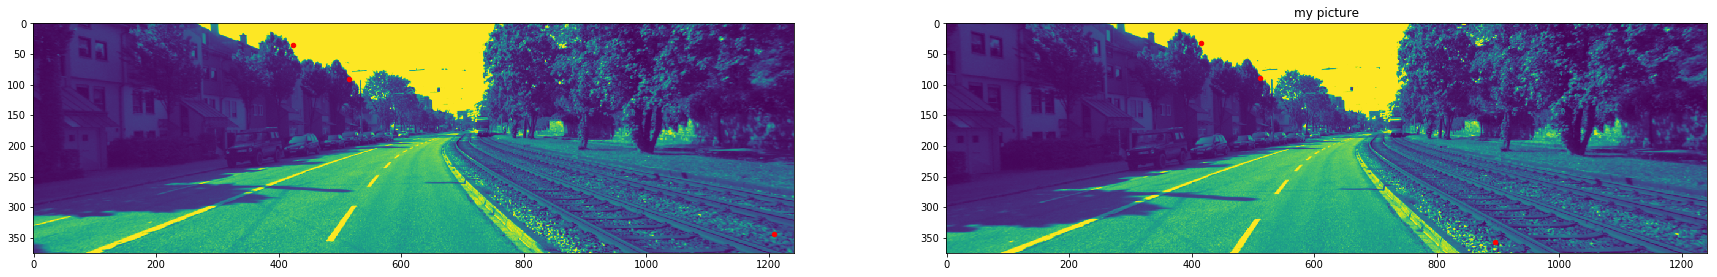

In [15]:
index = [5, 28, 94]

fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(x1[:,0][index], x1[:,1][index], c="r", s=20)
fig.add_subplot(1, 2, 2)
plt.imshow(img2)
plt.scatter(x2[:,0][index], x2[:,1][index], c="r", s=20)

plt.title('my picture')
plt.show()

In [ ]:
# get R|t



In [ ]:
def skew_matrix(v):
    zero = np.zeros_like(v[:, 0])
    
    M = np.stack([
                zero, -v[:,2], v[:,1],
                v[:,2], zero, -v[:,0],
                -v[:,1], v[:,0], zero,
                ], axis=1)
    return M


def get_episym(x1, x2, dR, dt):
    # calculate symetric distance for fundamental matrix
    num_point = len(x1)

    # Create homogeneous coordinate 
    x1 = np.concatenate([x1, np.ones((num_point, 1))], axis=-1).reshape(-1, 3, 1)
    x2 = np.concatenate([x2, np.ones((num_point, 1))], axis=-1).reshape(-1, 3, 1)
    
    # Compute fundamental matrix
    dR = dR.reshape(1,3,3)
    dt = dt.reshape(1,3)

    F = np.repeat(np.matmul(np.reshape(skew_matrix(dt), (-1, 3, 3)), dR).reshape(-1, 3, 3), num_point, axis=0)

    x2Fx1 = np.matmul(x2.transpose(0, 2, 1), np.matmul(F, x1)).flatten()
    Fx1 = np.matmul(F, x1).reshape(-1, 3)
    Ftx2 = np.matmul(F.transpose(0, 2, 1), x2).reshape(-1, 3)

    ys = x2Fx1**2 * (1.0 / (Fx1[..., 0]**2 + Fx1[..., 1]**2) + 1.0 / (Ftx2[..., 0]**2 + Ftx2[..., 1]**2))

    return ys.flatten()

ys = get_episym()